In [1]:
using BenchmarkTools
using GeodesicIntegration
using Plots; pyplot();

INFO: Recompiling stale cache file /Users/patrick/.julia/lib/v0.6/GeodesicIntegration.ji for module GeodesicIntegration.


Firstly, use a simple test case to verify that the module works as intended. The Schwarzschild metric predicts a stable circular orbit at $\ell/M=\sqrt{12}$ for timelike objects, which refers to 

$$r_{\text{ISCO}} = 6M$$

This is a good test case for the algorithm.

In [2]:
# Init
M = 5.0

scmetric = SchwarzschildMetric(M);

In [3]:
# Initial position
init_x = [0.0, 6.0M, π/2, 0.0];

# Initial 3-velocity; the time component is determined from normalization of 4-velocity
l = M*√12
init_u = [0.0, 0.0, l / evaluate(scmetric, init_x)[1][4, 4]];

# Set up the problem to be integrated -- uses geodesic equation in 4-geometry
problem = DirectGeodesicProblem(scmetric)

# Configure the integrator with the initial conditions and range
# Scaffolding returns total set of initial conditions for manifold projection callbacks
τspan      = (0.0, 400.0)
diffeq, X0 = scaffold(problem, init_x, init_u, τspan)

ε = killing_e(scmetric, init_x, X0[5])

# Assert energy and angular momentum conservation via manifold project callback
function g(r, u, p, t)
    r[1] = 0; r[2] = 0; r[3] = 0; r[4] = 0;
    r[5] = @. ((1 - (2M / u[2])) * u[5]) - ε
    r[6] = 0; r[7] = 0;
    r[8] = @. u[2]*u[2]*sin(u[3])*sin(u[3])*u[8] - l
end

cb = ManifoldProjection(g)

# Run
sol = solve(diffeq, reltol=1e-10, dense=true, save=true, callback=cb)

retcode: Success
Interpolation: 3rd order Hermite
t: 9-element Array{Float64,1}:
   0.0     
   0.139494
   0.75519 
   3.17638 
  11.736   
  39.1682  
 119.495   
 339.807   
 400.0     
u: 9-element Array{Array{Float64,1},1}:
 [0.0, 30.0, 1.5708, 0.0, 1.41421, 0.0, 0.0, 0.019245]                            
 [0.197274, 30.0, 1.5708, 0.00268456, 1.41421, 2.41983e-19, 1.58176e-21, 0.019245]
 [1.068, 30.0, 1.5708, 0.0145336, 1.41421, 1.31005e-18, 8.56334e-21, 0.019245]    
 [4.49209, 30.0, 1.5708, 0.0611295, 1.41421, 5.51015e-18, 3.6018e-20, 0.019245]   
 [16.5972, 30.0, 1.5708, 0.225859, 1.41421, 2.03587e-17, 1.33078e-19, 0.019245]   
 [55.3922, 30.0, 1.5708, 0.753793, 1.41421, 6.7946e-17, 4.44141e-19, 0.019245]    
 [168.991, 30.0, 1.5708, 2.29968, 1.41421, 2.26589e-17, 1.35499e-18, 0.019245]    
 [480.56, 30.0, 1.5708, 6.53959, 1.41421, 3.98888e-16, -2.31489e-18, 0.019245]    
 [565.685, 30.0, 1.5708, 7.698, 1.41421, 4.37433e-16, -3.18769e-18, 0.019245]     

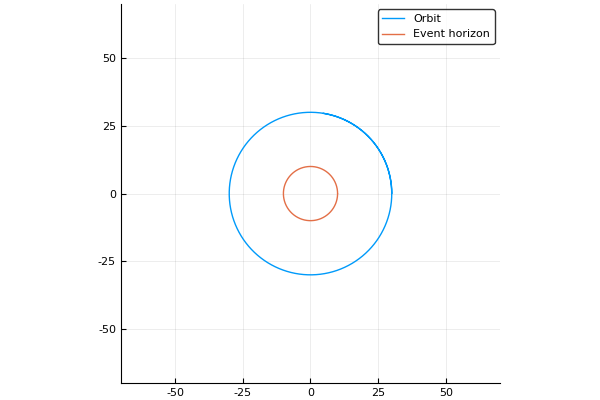

In [4]:
N  = 10
T  = τspan[2]
ts = linspace(0, τspan[2], N*T)

plot(sol(ts, idxs=2).*sin.(sol(ts, idxs=3)).*cos.(sol(ts, idxs=4)), 
    sol(ts, idxs=2).*sin.(sol(ts, idxs=3)).*sin.(sol(ts, idxs=4)), 
    aspect_ratio=1, label="Orbit")
ϕ = linspace(0, 2π, 1000)
plot!(2M*cos.(ϕ), 2M*sin.(ϕ), label="Event horizon", xlims=(-70, 70), ylims=(-70, 70))

The integration produces a beautiful circular orbit! Now to verify the residues from the theory: 

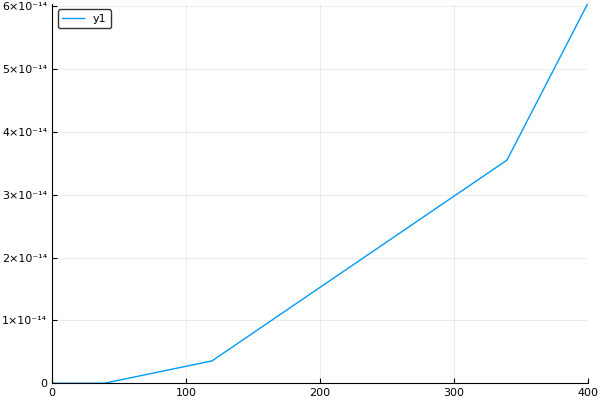

In [5]:
plot(sol.t, sol[2, :] - 6M)

The differences are within numerical uncertainty! Let's run the simulation for a long time and check how the manifold projection technique preserves our conserved quantities $\varepsilon$ and $\ell$:

In [9]:
τspan      = (0.0, 1e8)
diffeq, X0 = scaffold(problem, init_x, init_u, τspan)
sol        = solve(diffeq, reltol=1e-10, dense=true, save=true, callback=cb)

retcode: Success
Interpolation: 3rd order Hermite
t: 2642-element Array{Float64,1}:
    0.0      
    0.139494 
    0.75519  
    3.17638  
   11.736    
   39.1682   
  119.495    
  339.807    
  854.731    
 1754.23     
 2080.12     
 2336.46     
 2650.17     
    ⋮        
    7.56942e7
    7.66837e7
    7.78312e7
    7.94195e7
    8.11354e7
    8.30299e7
    8.51969e7
    8.77055e7
    9.05017e7
    9.37442e7
    9.72288e7
    1.0e8    
u: 2642-element Array{Array{Float64,1},1}:
 [0.0, 30.0, 1.5708, 0.0, 1.41421, 0.0, 0.0, 0.019245]                                 
 [0.197274, 30.0, 1.5708, 0.00268456, 1.41421, 2.41983e-19, 1.58176e-21, 0.019245]     
 [1.068, 30.0, 1.5708, 0.0145336, 1.41421, 1.31005e-18, 8.56334e-21, 0.019245]         
 [4.49209, 30.0, 1.5708, 0.0611295, 1.41421, 5.51015e-18, 3.6018e-20, 0.019245]        
 [16.5972, 30.0, 1.5708, 0.225859, 1.41421, 2.03587e-17, 1.33078e-19, 0.019245]        
 [55.3922, 30.0, 1.5708, 0.753793, 1.41421, 6.7946e-17, 4.44141e-19, 

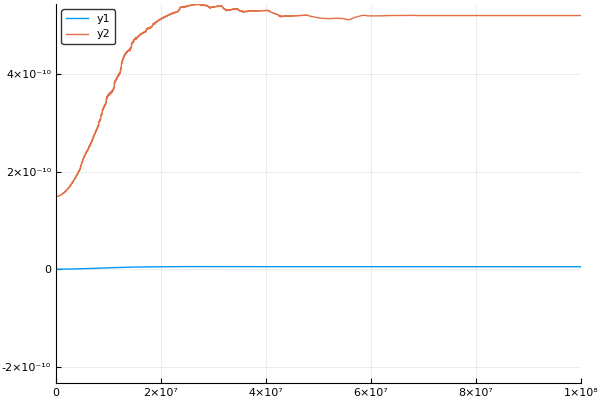

In [10]:
plot(sol.t, (1 - (2M ./ sol[2, :])) .* sol[5, :] - ε)
plot!(sol.t, (sol[2, :].^2 .* sin.(sol[3, :]).^2 .* sol[8, :]) - l)

Actual computation

In [83]:
problem = DirectGeodesicProblem(metric)
init_x  = [0.0, 5.0M, π/2, π/4]; # Initial x^μ for all test particles

init_u3_1 = [-1.8, 0.003, 0.08];
init_u3_2 = [-1.8, 0.003, 0.075];
init_u3_3 = [-1.8, 0.003, 0.09];
init_u3_4 = [-1.8, 0.003, 0.085];
init_u3_γ = [-1.8, 0.003, 0.0693];

tspan  = (0.0, 500.0)
diffeq1 = scaffold(problem, init_x, init_u3_1, tspan)
diffeq2 = scaffold(problem, init_x, init_u3_2, tspan)
diffeq3 = scaffold(problem, init_x, init_u3_3, tspan)
diffeq4 = scaffold(problem, init_x, init_u3_4, tspan)
diffeqγ = scaffold(problem, init_x, init_u3_γ, tspan, timelike=false)

sol1 = solve(diffeq1, reltol=1e-6);
sol2 = solve(diffeq2, reltol=1e-6);
sol3 = solve(diffeq3, reltol=1e-6);
sol4 = solve(diffeq4, reltol=1e-6);
solγ = solve(diffeqγ, reltol=1e-8);

In [84]:
matsol1 = sphericaltocartesian(sol1[:, :]')
matsol2 = sphericaltocartesian(sol2[:, :]')
matsol3 = sphericaltocartesian(sol3[:, :]')
matsol4 = sphericaltocartesian(sol4[:, :]')
matsolγ = sphericaltocartesian(solγ[:, :]')

7384×8 Array{Float64,2}:
   0.0        17.6777    17.6777     1.53081e-15  …  -0.00037392   -1.79999 
   0.251678   17.5061    17.6743    -0.00514842      -0.000380746  -1.79618 
   2.06908    16.2724    17.6445    -0.0419278       -0.000433391  -1.76768 
   5.62275    13.8869    17.5543    -0.111705        -0.000554189  -1.70667 
  10.0643     10.9549    17.3649    -0.194497        -0.000738804  -1.62054 
  15.2986      7.5709    16.9926    -0.284747     …  -0.000994937  -1.50568 
  21.5016      3.67497   16.2596    -0.379318        -0.00130478   -1.35451 
  28.0396     -0.242075  15.0216    -0.461011        -0.00152508   -1.18576 
  35.1174     -4.1207    13.0031    -0.523781        -0.00147524   -1.00551 
  42.7928     -7.61912    9.93733   -0.556236        -0.000976145  -0.828677
  51.4202    -10.2116     5.53986   -0.544485     …   3.24619e-5   -0.66724 
  62.0731    -10.8292    -0.522877  -0.462686         0.00153837   -0.530885
  73.1551     -8.28349   -6.06642   -0.317192      

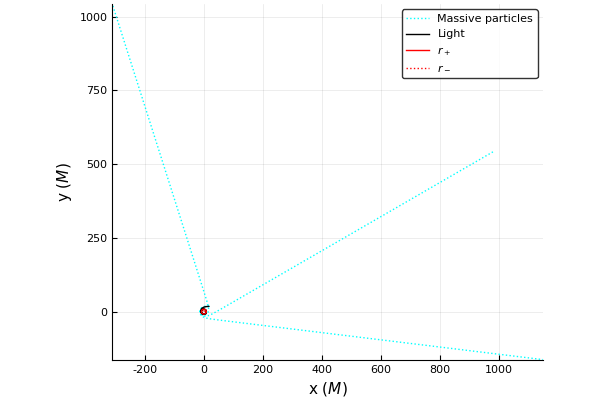

In [86]:
plt = plot(matsol1[:, 2], matsol1[:, 3], aspect_ratio=1, ls=:dot, lc=:cyan, label="")
plot!(matsol2[:, 2], matsol2[:, 3], ls=:dot, lc=:cyan, label="Massive particles")
plot!(matsol3[:, 2], matsol3[:, 3], ls=:dot, lc=:cyan, label="")
plot!(matsol4[:, 2], matsol4[:, 3], ls=:dot, lc=:cyan, label="")
plot!(matsolγ[:, 2], matsolγ[:, 3], lc=:black, label="Light")

rp = M + sqrt(M*M - a*a - q*q) 
rm = M - sqrt(M*M - a*a - q*q) 

ϕ = linspace(0, 2π, 100)
plot!(rp*cos.(ϕ), rp*sin.(ϕ), color=:red, label="\$r_+\$", #=xlims=(-40, 40), ylims=(-40, 40)=#)
plot!(rm*cos.(ϕ), rm*sin.(ϕ), color=:red, ls=:dot, label="\$r_-\$")
xlabel!("x (\$M\$)")
ylabel!("y (\$M\$)")
# png("infall"); plt